## 2. 有哪些跨市场套利指标？

## 目录
1. Relative Strength
2. Bollinger Band Divergence
3. Intermarket Disparity
4. Intermarket LRS Divergence
5. Intermarket Regression Divergence
6. Intermarket Momentum Oscillator
7. Z-Score Divergence
8. Multiple Intermarket Divergence
9. Multiple regression Divergence
10. Congestion Index

## Relative Strength
$SEC_1/SEC_2$

            SEC_1  SEC_2        RS
date                              
2017-05-11   4.93   3.41  1.445748
2017-05-12   5.06   3.46  1.462428
2017-05-15   5.10   3.44  1.482558
2017-05-16   5.00   3.41  1.466276
2017-05-17   4.96   3.41  1.454545


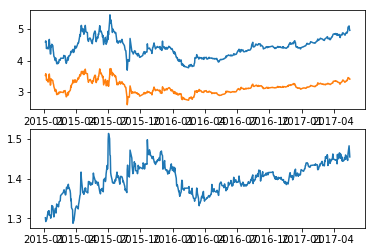

In [1]:
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt

SEC_1 = ts.get_k_data('601398', start='2015-01-01', ktype='D', autype='qfq')
SEC_1.index = pd.to_datetime(SEC_1['date'], format='%Y-%m-%d')

SEC_2 = ts.get_k_data('601288', start='2015-01-01', ktype='D', autype='qfq')
SEC_2.index = pd.to_datetime(SEC_2['date'], format='%Y-%m-%d')

SEC_df = pd.concat([SEC_1.close, SEC_2.close], axis=1)
SEC_df.columns = ['SEC_1', 'SEC_2']

SEC_df['RS'] = SEC_df.SEC_1/SEC_df.SEC_2

print SEC_df.tail()

plt.subplot(2,1,1)
plt.plot(SEC_df.SEC_1)
plt.plot(SEC_df.SEC_2)
plt.subplot(2,1,2)
plt.plot(SEC_df.RS)
plt.show()

## Bollinger Band Divergence
$SEC_1BOL = 1+\frac{(C-MA+2SD)}{4SD}$

$DIVERGENCE = EMA(3)[\frac{(SEC_2BOL-SEC_1BOL)}{SEC_1BOL}*100]$

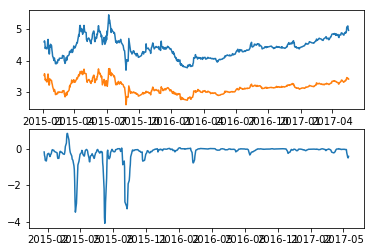

In [2]:
import talib as ta

def SD(series, window=10):
    return series.rolling(window).std()

SEC_df['SEC_1_SD'] = SD(SEC_df.SEC_1)
SEC_df['SEC_2_SD'] = SD(SEC_df.SEC_2)
SEC_df['SEC_1_MA'] = ta.abstract.MA(SEC_df, 10, price='SEC_1')
SEC_df['SEC_2_MA'] = ta.abstract.MA(SEC_df, 10, price='SEC_2')

SEC_1_BOL = 1+(SEC_df.SEC_1-SEC_df.SEC_1_MA+2*SEC_df.SEC_1_SD)/4*SEC_df.SEC_1_SD
SEC_2_BOL = 1+(SEC_df.SEC_2-SEC_df.SEC_2_MA+2*SEC_df.SEC_2_SD)/4*SEC_df.SEC_2_SD
DIV = (SEC_2_BOL-SEC_1_BOL)/SEC_1_BOL*100
DIVERGENCE = pd.Series(ta.EMA(DIV.values, 3),index=DIV.index)

plt.subplot(2,1,1)
plt.plot(SEC_df.SEC_1)
plt.plot(SEC_df.SEC_2)
plt.subplot(2,1,2)
plt.plot(DIVERGENCE)
plt.show()

## Intermarket Disparity

$DS_1=\frac {(SEC_1-MA(SEC_1))}{MA(SEC_1)*100}$

$DS_2=\frac {(SEC_2-MA(SEC_2))}{MA(SEC_2)*100}$

$Intermarket Disparity (ID)=c*DS_2-DS_1$

date
2017-05-11    0.263542
2017-05-12   -0.780424
2017-05-15   -1.907471
2017-05-16   -0.626029
2017-05-17    0.194465
dtype: float64


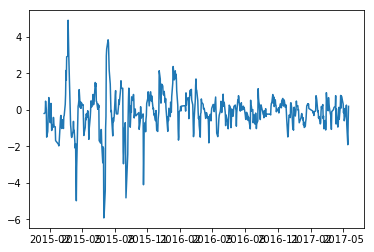

In [3]:
# print SEC_df
DS_1 = (SEC_df.SEC_1-SEC_df.SEC_1_MA)/SEC_df.SEC_1_MA*100
DS_2 = (SEC_df.SEC_2-SEC_df.SEC_2_MA)/SEC_df.SEC_2_MA*100
ID = 1*DS_2-DS_1 
print ID.tail()
plt.plot(ID)
plt.show()

## Intermarket LRS Divergence
$LRS = Slope(SEC_1)-Slope(SEC_2)$

date
2017-05-11    0.003333
2017-05-12    0.007697
2017-05-15    0.014121
2017-05-16    0.014121
2017-05-17    0.011394
dtype: float64


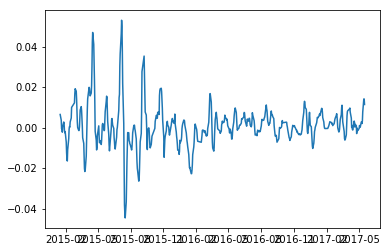

In [4]:
slope_SEC_1 = ta.abstract.LINEARREG_SLOPE(SEC_df, 10, price='SEC_1')
slope_SEC_2 = ta.abstract.LINEARREG_SLOPE(SEC_df, 10, price='SEC_2')

LRS = slope_SEC_1 - slope_SEC_2
print LRS.tail()
plt.plot(LRS)
plt.show()

## Intermarket Regression Divergence
$Y(Pred)=r*\frac{std(Y)}{std(X)}*X+MA(Y)-MA(X)*r*std(Y)/std(X)$

$IRD = Y(Pred)-Y(Actual)$

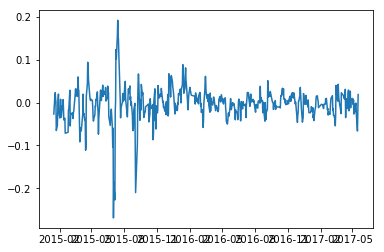

In [5]:
Y = SEC_df.SEC_1
X = SEC_df.SEC_2

SEC_df['r'] = X.rolling(10).corr(Y)

Y_Pred = SEC_df.r*SEC_df.SEC_1_SD/SEC_df.SEC_2_SD*X+ SEC_df.SEC_1_MA-SEC_df.SEC_2_MA*SEC_df.r*SEC_df.SEC_1_SD/SEC_df.SEC_2_SD

IRD = Y_Pred - Y
plt.plot(IRD)
plt.show()

## Intermarket Momentum Oscillator
$\frac {MA(IRD - lowest(IRD,200))*100, 3)}{MA(highest(IRD, 200)-lowest(IRD, 200))}$

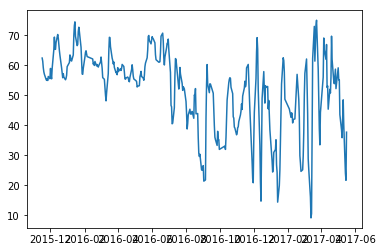

In [6]:
def lowest(series, window=200):
    return series.rolling(window).min()

def highest(series, window=200):
    return series.rolling(window).max()

n = (IRD - lowest(IRD))*100
numerator = pd.Series(ta.MA(n.values, 3), index=n.index)
d = highest(IRD)-lowest(IRD)
denominator = pd.Series(ta.MA(d.values, 3), index=d.index)

IMO = numerator/denominator

plt.plot(IMO)
plt.show()

## Z-Score Divergence
$Z=\frac{(C-MA)}{SD}$

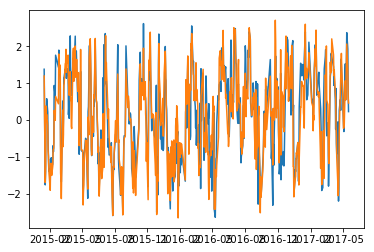

In [7]:
Z1 = (SEC_df.SEC_1 - SEC_df.SEC_1_MA)/SEC_df.SEC_1_SD
Z2 = (SEC_df.SEC_2 - SEC_df.SEC_2_MA)/SEC_df.SEC_2_SD
plt.plot(Z1)
plt.plot(Z2)
plt.show()

## Multiple Intermarket Divergence
$r_{y1(2)} = \frac {r_{y1}-r_{y2}r_{12}}{\sqrt{1-r^2_{12}}}$

$r_{y2(1)} = \frac {r_{y2}-r_{y1}r_{12}}{\sqrt{1-r^2_{12}}}$


## Multiple regression Divergence
$Y= a + b_1X_1+b_2X_2+...b_kX_k$

用大盘，成交量，SEC_2来回归SEC_1

In [8]:
hs300 = ts.get_hist_data('hs300', start='2015-01-01', ktype='D').close
hs300.index = pd.to_datetime(hs300.index, format='%Y-%m-%d')
# print SEC_2
adv = ta.abstract.MA(SEC_1, 10, price='volume')
SEC_1_C = SEC_1.close
SEC_2_C = SEC_2.close

df = pd.concat([hs300, adv, SEC_1_C, SEC_2_C], axis=1, keys=['hs300', 'adv', 'SEC_1_C', 'SEC_2_C'])
df = df.dropna()

import statsmodels.api as sm
from statsmodels import regression
import numpy as np

model = regression.linear_model.OLS(df['SEC_1_C'], sm.add_constant(np.column_stack((df['hs300'],
                                                                                    df['adv'],
                                                                                    df['SEC_2_C']
                                                                                    )))).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SEC_1_C   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1189.
Date:                Thu, 18 May 2017   Prob (F-statistic):          7.16e-243
Time:                        09:23:54   Log-Likelihood:                 433.06
No. Observations:                 566   AIC:                            -858.1
Df Residuals:                     562   BIC:                            -840.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5830      0.094     -6.235      0.000      -0.767      -0.399
x1         -4.401e-06   1.53e-05     -0.288      0.774   -3.44e-05    2.56e-05
x2         -1.755e-08   2.12e-09     -8.279      0.000   -2.17e-08   -1.34e-08
x3             1.6045      0.036     44.009      0.000       1.533       1.676
==============================================================================
Omnibus:                       13.401   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.254
Skew:                           0.144   Prob(JB):                     1.47e-05
Kurtosis:                       3.928   Cond. No.                     8.56e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.56e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
better_model = regression.linear_model.OLS(df['SEC_1_C'], sm.add_constant(np.column_stack((
                                                                                    df['adv'],
                                                                                    df['SEC_2_C']
                                                                                    )))).fit()

better_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SEC_1_C   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1787.
Date:                Thu, 18 May 2017   Prob (F-statistic):          1.56e-244
Time:                        09:23:57   Log-Likelihood:                 433.02
No. Observations:                 566   AIC:                            -860.0
Df Residuals:                     563   BIC:                            -847.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5797      0.093     -6.252      0.000      -0.762      -0.398
x1          -1.78e-08   1.92e-09     -9.260      0.000   -2.16e-08    -1.4e-08
x2             1.5987      0.030     52.680      0.000       1.539       1.658
==============================================================================
Omnibus:                       13.665   Durbin-Watson:                   0.097
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.479
Skew:                           0.154   Prob(JB):                     1.31e-05
Kurtosis:                       3.926   Cond. No.                     8.43e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

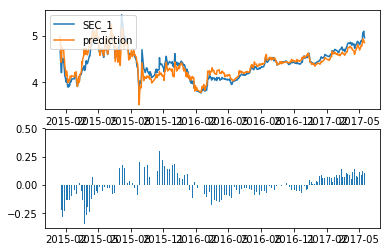

In [10]:
prediction = better_model.params[0] + better_model.params[1]*df['adv'] + better_model.params[2]*df['SEC_2_C']
prediction.name = 'Prediction'
divergence = df['SEC_1_C']-prediction

plt.subplot(2,1,1)
plt.plot(df['SEC_1_C'], label='SEC_1')
plt.plot(prediction, label='prediction')
plt.legend(loc='upper left')
plt.subplot(2,1,2)
plt.bar(df['SEC_1_C'].index, divergence)
plt.show()

## Congestion Index
$CI= \frac {(C-C[X-1])/C[X-1]*100} {(Higest(H,X)-Lowest(L,X))/Lowest(L,X)}$

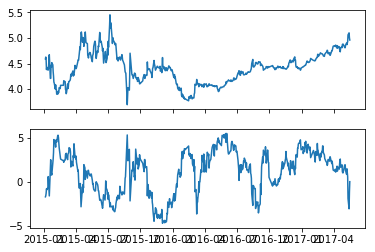

In [25]:
# print SEC_1


def C_Index(SEC, window=20):
    list_CI = []
    for i in range(0,len(SEC)):
        data_S = SEC.iloc[i:i+window]
        C = data_S.close.iloc[-1]
        C_W = data_S.close.iloc[0]
        H_W = max(data_S.high)
        L_W = min(data_S.low)
        CI = (C-C_W)/C_W*100/(H_W-L_W)/L_W
        list_CI.append(CI)
    return list_CI

Congestion_Index = C_Index(SEC_1, window=50)
CI = pd.Series(Congestion_Index, index=SEC_1.index)
fig,(ax,ax1) = plt.subplots(2,1,sharex=True)
ax.plot(SEC_1.close)
ax1.plot(CI)
plt.show()